# <u>House Prices: Simple and elegant way of predicting house price</u>
This notebook will guide you through effective steps to submit.

* [1. Preparations](#1)
    * [1.1 Import libraries](#1.1)
    * [1.2 Load dataset](#1.2)
    * [1.3 Check data](#1.3)
    * [1.4 Combine train and test](#1.4)
* [2. Feature Engineering](#2)
    * [2.1 Transform numeric into logarithms](#2.1)
    * [2.2 Transform categorical into one-hot vector](#2.2)
* [3. Prediction and submission](#3)
    * [3.1 Format data](#3.1)
    * [3.2 Prediction](#3.2)
    * [3.3 Create submission](#3.3)

<a id="1"></a><h1 style='background:slateblue; border:.; color:white'><center>1. Preparations</center></h1>

## 1.1 Import libraries<a id="1.1"></a>
**Import all required libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

## 1.2 Load dataset<a id="1.2"></a>
**Load each data as a Pandas DataFrame**

In [2]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 1.3 Check data<a id="1.3"></a>
**check data shape, count and dtype of each column**

In [5]:
print('=========== train infomation ===========')
train.info()
print('\n\n=========== test infomation ===========')
test.info()

=========== train infomation ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual

## 1.4 Combine train and test<a id="1.4"></a>
**Combine train and test so that you can do each future operation once**

In [6]:
data = pd.concat([train, test])
data.shape

(2919, 81)

## 1.4 fill NA<a id="1.4"></a>
use the imputer to fill the NA


In [7]:
data.shape

(2919, 81)

In [8]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)
data.isnull().sum(axis = 0)

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

<a id="2"></a><h1 style='background:slateblue; border:.; color:white'><center>2. Feature Engineering</center></h1>

## 2.1 Transform numeric into logarithms<a id="2.1"></a>
**transform all numeric columns of the data frame into logarithms to reduce skewness**<br><br>
Approximating to a normal distribution often improves the accuracy of machine learning.<br>Logarithmic conversion reduces the range when the feature scale is large and expands it when the feature scale is small.<br>This often allows you to get closer to a mountainous distribution as if you were crushing a long-tailed distribution.

In [9]:
# current numeric data
numerics = data.loc[:,data.dtypes != 'object'].drop('Id', axis=1)
numerics['value_proposition'] = numerics['YearBuilt'] * numerics['OverallQual']
numerics['finished_basement'] = numerics['BsmtFinSF1'] > 0
numerics['garage_value'] = numerics['YearBuilt'] * numerics['GarageCars']
numerics.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,value_proposition,finished_basement,garage_value
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500.0,14021,True,4006.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500.0,11856,True,3952.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,223500.0,14007,True,4002.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,140000.0,13405,True,5745.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,250000.0,16000,True,6000.0


In [10]:
tmp = numerics.drop('SalePrice', axis = 1)
tmp.isnull().sum(axis = 0)

MSSubClass             0
LotFrontage          486
LotArea                0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
MasVnrArea            23
BsmtFinSF1             1
BsmtFinSF2             1
BsmtUnfSF              1
TotalBsmtSF            1
1stFlrSF               0
2ndFlrSF               0
LowQualFinSF           0
GrLivArea              0
BsmtFullBath           2
BsmtHalfBath           2
FullBath               0
HalfBath               0
BedroomAbvGr           0
KitchenAbvGr           0
TotRmsAbvGrd           0
Fireplaces             0
GarageYrBlt          159
GarageCars             1
GarageArea             1
WoodDeckSF             0
OpenPorchSF            0
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
PoolArea               0
MiscVal                0
MoSold                 0
YrSold                 0
value_proposition      0
finished_basement      0
garage_value           1
dtype: int64

In [11]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(tmp)
tmp[tmp.columns] = imp_mean.transform(tmp)
tmp.isnull().sum(axis = 0)

MSSubClass           0
LotFrontage          0
LotArea              0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
BsmtFinSF1           0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
1stFlrSF             0
2ndFlrSF             0
LowQualFinSF         0
GrLivArea            0
BsmtFullBath         0
BsmtHalfBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenAbvGr         0
TotRmsAbvGrd         0
Fireplaces           0
GarageYrBlt          0
GarageCars           0
GarageArea           0
WoodDeckSF           0
OpenPorchSF          0
EnclosedPorch        0
3SsnPorch            0
ScreenPorch          0
PoolArea             0
MiscVal              0
MoSold               0
YrSold               0
value_proposition    0
finished_basement    0
garage_value         0
dtype: int64

In [12]:
numerics[numerics.drop('SalePrice', axis = 1).columns] = tmp

In [13]:
numerics.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,value_proposition,finished_basement,garage_value
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,14021.0,1.0,4006.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,11856.0,1.0,3952.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,14007.0,1.0,4002.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,13405.0,1.0,5745.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,16000.0,1.0,6000.0


In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler
noyear = ~numerics.columns.str.contains('Yr|Year|SalePrice', regex=True)
noyear = numerics.columns [noyear]
print(noyear)
numerics[noyear] = scaler.fit_transform(numerics[noyear])
numerics.head

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'value_proposition', 'finished_basement',
       'garage_value'],
      dtype='object')


<bound method NDFrame.head of       MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.235294     0.150685  0.033420     0.666667        0.500     2003.0   
1       0.000000     0.202055  0.038795     0.555556        0.875     1976.0   
2       0.235294     0.160959  0.046507     0.666667        0.500     2001.0   
3       0.294118     0.133562  0.038561     0.666667        0.500     1915.0   
4       0.235294     0.215753  0.060576     0.777778        0.500     2000.0   
...          ...          ...       ...          ...          ...        ...   
1454    0.823529     0.000000  0.002973     0.333333        0.750     1970.0   
1455    0.823529     0.000000  0.002776     0.333333        0.500     1970.0   
1456    0.000000     0.476027  0.087406     0.444444        0.750     1960.0   
1457    0.382353     0.140411  0.042726     0.444444        0.500     1992.0   
1458    0.235294     0.181507  0.038921     0.666667        0.500     1993.0   

      Yea

The skewnesses of many features are reduced by logarithmic conversion. Some skewnesses have increased, but overall it has decreased.

## 2.2 Transform categorical into one-hot vector<a id="2.2"></a>
**transform all categorical columns of the data frame into one-hot vector**<br><br>
Since GBDT treats features as numerical data, it is necessary to convert categorical data to numerical values. Label encoding is fine, but one-hot encoding often has better performance.

In [15]:
## for RF regressor no one hot encoding used
cat_cols = data.loc[:,data.dtypes == 'object'].columns
data.loc[:,cat_cols].head()
cat_data = data.loc[:, cat_cols]
cat_data.head()
for i in cat_cols.values:

    labels = cat_data[i].astype('category').cat.categories.tolist()
    replace_map_comp = {i : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    cat_data.replace(replace_map_comp, inplace=True)

cat_data = cat_data.fillna(0)
cat_data.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,4.0,2,0.0,4,4,1.0,5,1,6,3,3,1,6,2,2,13.0,14.0,2.0,3,5,3,3.0,4.0,4.0,3.0,6.0,2,1,2,5.0,3.0,7.0,0.0,2.0,2.0,5.0,5.0,3,0.0,0.0,0.0,9.0,5
1,4.0,2,0.0,4,4,1.0,3,1,25,2,3,1,3,2,2,9.0,9.0,3.0,4,5,2,3.0,4.0,2.0,1.0,6.0,2,1,2,5.0,4.0,7.0,5.0,2.0,2.0,5.0,5.0,3,0.0,0.0,0.0,9.0,5
2,4.0,2,0.0,1,4,1.0,5,1,6,3,3,1,6,2,2,13.0,14.0,2.0,3,5,3,3.0,4.0,3.0,3.0,6.0,2,1,2,5.0,3.0,7.0,5.0,2.0,2.0,5.0,5.0,3,0.0,0.0,0.0,9.0,5
3,4.0,2,0.0,1,4,1.0,1,1,7,3,3,1,6,2,2,14.0,16.0,3.0,4,5,1,4.0,2.0,4.0,1.0,6.0,2,3,2,5.0,3.0,7.0,3.0,6.0,3.0,5.0,5.0,3,0.0,0.0,0.0,9.0,1
4,4.0,2,0.0,1,4,1.0,3,1,16,3,3,1,6,2,2,13.0,14.0,2.0,3,5,3,3.0,4.0,1.0,3.0,6.0,2,1,2,5.0,3.0,7.0,5.0,2.0,2.0,5.0,5.0,3,0.0,0.0,0.0,9.0,5


<a id="3"></a>
<h1 style='background:slateblue; border:.; color:white'><center>3. Prediction and submission</center></h1>

## 3.1 Format data<a id="3.1"></a>
**Format data for training**

In [16]:
# merge categorical and numeric columns
optimized_data = pd.concat([data['Id'], cat_data, numerics], axis=1)
optimized_data.head()
# split data into X_train, y_train and test
train = optimized_data[:train.shape[0]]
test = optimized_data[train.shape[0]:].drop(['Id', 'SalePrice'], axis=1)
X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_train = train['SalePrice']

> ## 3.2 learn and Prediction<a id="3.2"></a>
**fit and predict using lightGBM**

In [17]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [18]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    

SEED = 42
set_seed(SEED)



In [19]:
# train
%time


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110,120,130,140,150],
    'max_features': [2, 3,4,5],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 25, 50, 100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
model_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)


model_rf.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_rf.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_rf.best_score_:.3f}'
)
print(model_rf.get_params())
print('-----')


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs
Fitting 5 folds for each of 2688 candidates, totalling 13440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

-----
Best parameters {'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.851
{'cv': 5, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'bootstrap': [True], 'max_depth': [80, 90, 100, 110, 120, 130, 140, 150], '

In [20]:
from sklearn.linear_model import ElasticNet
# Create the parameter grid based on the results of random search 
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

elastic_net = ElasticNet()

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.001,0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)

# Instantiate the grid search model
model_glm = GridSearchCV(estimator = elastic_net, 
                   param_grid = param_grid, 
                    cv = 5, n_jobs = -1, verbose = 2)


model_glm.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_glm.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_glm.best_score_:.3f}'
)
print(model_glm.get_params())
print('-----')

Fitting 5 folds for each of 91 candidates, totalling 455 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    6.3s


-----
Best parameters {'alpha': 0.01, 'l1_ratio': 0.7}
Mean cross-validated accuracy score of the best_estimator: 0.823
{'cv': 5, 'error_score': nan, 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__l1_ratio': 0.5, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': ElasticNet(), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'l1_ratio': [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 2}
-----


[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    7.4s finished


In [21]:
# Various hyper-parameters to tune
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.01,.03, 0.05, .07], #so called `eta` value
              'max_depth': [3,4,5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

model_xgb = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)


model_xgb.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_xgb.best_score_:.3f}'
)
print(model_xgb.get_params())
print('-----')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


[01:54:24] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:54:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:26] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
-----
Best parameters {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Mean cross-validated accuracy score of the best_estimator: 0.896
{'cv': 5, 'error_score': nan, 'estimator__objective': 'reg:squarederror', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__colsample_bylevel': None, 'estimator_

> ## 3.3 Create submission<a id="3.3"></a>
**convert prediction into exponent and export CSV file**

Here we are taking a look into the prediction on the training data:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff575abd810>,
      dtype=object)

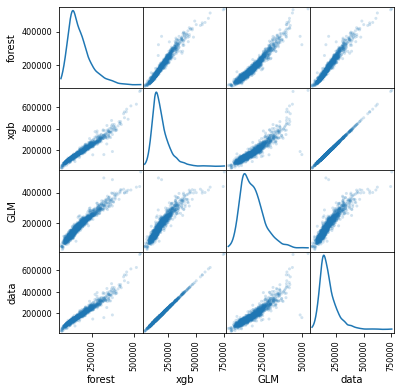

In [23]:
from pandas.plotting import scatter_matrix

forest_train_pred = model_rf.predict(X_train)
xgb_train_pred = model_xgb.predict(X_train)
lgbm_train_pred = model_glm.predict(X_train)


base_pred = pd.DataFrame({
    'forest':forest_train_pred.ravel(), 
    'xgb':xgb_train_pred.ravel(), 
    'GLM': lgbm_train_pred.ravel(),
    'data': y_train

})
scatter_matrix(base_pred, alpha=0.2, figsize=(6, 6), diagonal='kde')




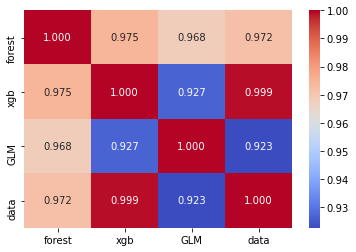

In [24]:
g = sns.heatmap(base_pred.corr(),annot=True, fmt = ".3f", cmap = "coolwarm" )

In [25]:
base_pred.columns.values

array(['forest', 'xgb', 'GLM', 'data'], dtype=object)

In [26]:
base_pred = pd.DataFrame({
    'forest':forest_train_pred.ravel(), 
    'xgb':xgb_train_pred.ravel(), 
    'GLM': lgbm_train_pred.ravel()
})

In [30]:
def create_submission(model, X_test, test_house_id, model_name):
    y_pred_test = model.predict(X_test)
    submission = pd.DataFrame(
        {
            'houseID': test_house_id, 
            'Predicted_price': y_pred_test,
        }
    )
    print(model_name)
    print(submission.head())
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    return submission

In [31]:
# convert logarithms into exponent

pred_glm = create_submission(model_glm, test[X_train.columns], test.index.values, 'glm')
pred_xgboost = create_submission(model_xgb, test[X_train.columns], test.index.values, 'xgboost')
pred_rf = create_submission(model_rf, test[X_train.columns], test.index.values, 'rf')



glm
   houseID  Predicted_price
0        0    110766.720831
1        1    150600.279385
2        2    170381.452114
3        3    187726.072339
4        4    189165.069195
xgboost
   houseID  Predicted_price
0        0    125123.835938
1        1    160215.156250
2        2    188872.765625
3        3    195702.953125
4        4    182716.156250
rf
   houseID  Predicted_price
0        0    128993.508475
1        1    151550.645071
2        2    183205.856601
3        3    187642.375970
4        4    194355.535793


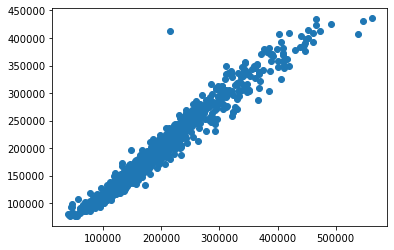

In [32]:
plt.scatter(pred_xgboost.Predicted_price.values,pred_rf.Predicted_price.values)

This notebook has a score of 0.13142 and is in the top 30%.<br>Based on this notebook, Feature engineering, Hyper-parameter tuning and ensemble will give you a better score.

In [33]:
pred_xgboost.head()

,houseID,Predicted_price
0,0,125123.835938
1,1,160215.156250
2,2,188872.765625
3,3,195702.953125
4,4,182716.156250


taking a look at correlation of prediction in the test set

In [ ]:
from pandas.plotting import scatter_matrix
test_pred = pd.concat([pred_xgboost.Predicted_price,
                         pred_rf.Predicted_price, 
                         pred_glm.Predicted_price], axis=1)
test_pred.columns = ['xgboos', 'RF', 'GLM']
scatter_matrix(test_pred, alpha=0.2, figsize=(6, 6), diagonal='kde')


In [ ]:
g = sns.heatmap(test_pred.corr(),annot=True, fmt = ".3f", cmap = "coolwarm" )

New prediction using ensemble of 3 different models predictions:

In [ ]:
%%time
from sklearn.svm import SVR

param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
         'C' : [1,5,10],'degree' : [3,5,8],
         'coef0' : [0.01,10,0.5],
         'gamma' : ('auto','scale')},

modelsvr = SVR()

final_model = GridSearchCV(estimator = modelsvr, param_grid = param, 
                          cv = 5, n_jobs = -1, verbose = 2)

final_model.fit(base_pred, y_train)

print(score(y_train, final_model.predict(base_pred)))
print(final_model.best_score_)
# print(accuracy_score(y_val, model_xgb.predict(X_val)))
print(final_model.best_params_)
print(final_model.best_estimator_)


In [ ]:
final_pred = final_model.predict(test_pred)
final_pred = pd.concat([test['Id'], final_pred])
submission = pd.DataFrame(
    { 
        'houseID': test_df['Id'], 
        'Predicted_price': final_pred
    }
)
submission.to_csv("submission_final.csv", index=False)